In [ ]:
"""
Incluye doblado con FFT y suavizado con Savizky-Golay (recomendable solo p/calibraciones de baja estadística)
El archivo ".mos" o ".Asc" de entrada no debe tener encabezado
Preparando para Colab e importando librerías necesarias.
"""
!pip install lmfit
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
img = '/content/drive/MyDrive/Colab-Notebooks/PyMossFit/Opportunity_Rover/B067RR0.Asc'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lmfit import Parameters, minimize, fit_report
from scipy.constants import *
from scipy.integrate import trapz
from scipy.signal import savgol_filter
from pathlib import Path

path= Path(img); name= path.stem; title= path.parent.name; full= path.parents[0]; print(name, title, full)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.9 MB/s eta 0:00:00
Mounted at /content/drive/
B067RR0 Opportunity_Rover /content/drive/MyDrive/Colab-Notebooks/PyMossFit/Opportunity_Rover


Ingrese la fecha de calibración (AAAAMMDD): 20040923
Ingrese el rango de V (en mm/s): 12


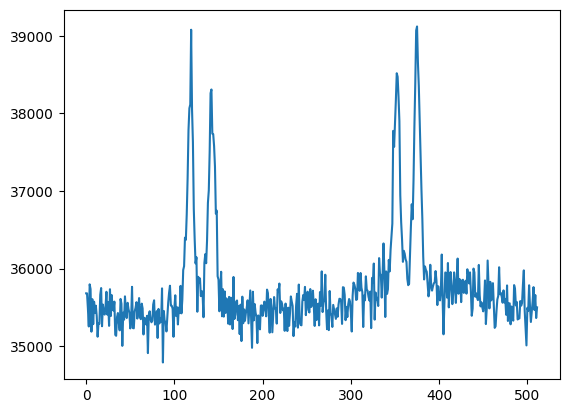

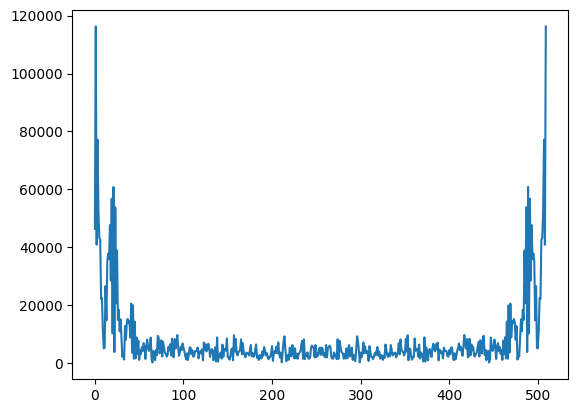

Media del fondo: 70939
Canal de doblado: 256


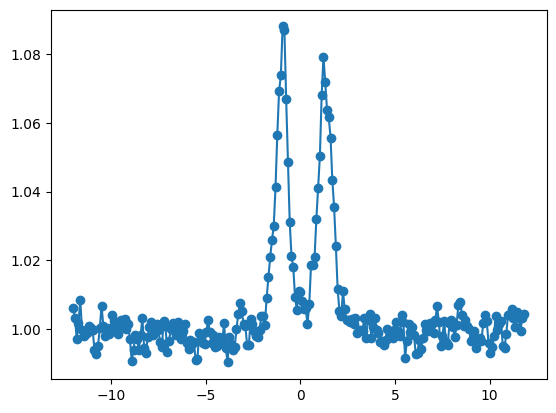

In [ ]:
"""
Para doblar, normalizar y calibrar en mm/s, los archivos del espectrómetro de CNEA de 512 canales
"""
y= np.loadtxt(img, delimiter=","); y=y[:,9] #agregar delimiter="," o delimiter=" " en loadtxt si es de dos columnas. Caso contrario comentar y=y[:,1]
N=len(y); N2=int(N/2); N4=int(N/4)

fecha = str(input('Ingrese la fecha de calibración (AAAAMMDD): '),)
vel = float(input('Ingrese el rango de V (en mm/s): ' ), )
np.savetxt(f"{full}/{name}-calib.txt", (fecha,vel, N), fmt='%s')

#y= savgol_filter(y, 5, 2) #solo si se trata de espectro con baja estadística, comentar en otro caso
plt.plot(y)
plt.show()

"""
Doblado con FFT (basado en el Nyquist-Shannon sampling theorem, https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html)
"""
f= abs(np.fft.fft(y)); Nf=pd.Series(f[N2-1:N2+1]).idxmin()+(N2-1)
plt.plot(f[1:N-1])
plt.show()

#Nf=128
for i in range(0, Nf-1):
    y[[i]]=y[[i]]+y[[-(N-1)+i]]

y=y[0:N2-1]

"""
Normalización
"""
y2= np.concatenate([y[2:30],y[N2-30:N2-2]])

y_bckg=np.mean(y2)
y_bckg=int(y_bckg)

for i in range(0, N2-1):
    y[[i]]=y[[i]]/y_bckg

x=np.arange(1,N2)

"""
de canales a escala de velocidades en mm/s
"""
v=np.loadtxt(f"{full}/{name}-calib.txt"); vmax=v[[1]]

x=np.linspace(start = 0, stop = N2-1, num= N2)

for i in range(0, N2-1):
    x[[i]]=(i-N4)*vmax/N4

x= x[0:N2-1]

print('Media del fondo:', y_bckg); print('Canal de doblado:', Nf)

plt.plot(x,y, marker="o")
plt.show()

np.savetxt(f"{full}/{name}.csv", list(zip(x,y)), delimiter=",", fmt='%1.6f')

<ipython-input-3-c2f6990df699>:67: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  int1= trapz(-1+z1, x); int2= trapz(-1+z2, x)


ancho1 (sigma1/sqrt(2)) es: 0.32 mm/s
Centroide1 (ISO1) es: 0.165 mm/s
Amplitud1 (a1) es: 0.0496
Doblete1 es: -2.056 mm/s
área1: 64.1 %
ancho2 (sigma2/sqrt(2)) es: 0.32 mm/s
Centroide2 (ISO2) es: 0.209 mm/s
Amplitud2 (a2) es: 0.0278
Doblete2 es: 2.735 mm/s
área2: 35.9 %
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 99
    # data points      = 255
    # variables        = 6
    chi-square         = 0.00366162
    reduced chi-square = 1.4705e-05
    Akaike info crit   = -2831.53358
    Bayesian info crit = -2810.28600
[[Variables]]
    b1:  0.45 (fixed)
    m1:  0.16479685 +/- 0.00646576 (3.92%) (init = 1.1)
    d1: -2.05613693 +/- 0.01793859 (0.87%) (init = 2.1)
    a1:  0.04957476 +/- 0.00194298 (3.92%) (init = 0.02)
    b2:  0.45 (fixed)
    m2:  0.20859345 +/- 0.01152415 (5.52%) (init = 1.2)
    d2:  2.73531202 +/- 0.03215044 (1.18%) (init = 2.5)
    a2:  0.02775864 +/- 0.00194340 (7.00%) (init = 0.01)
[[Correlations]] (unreported correlations are

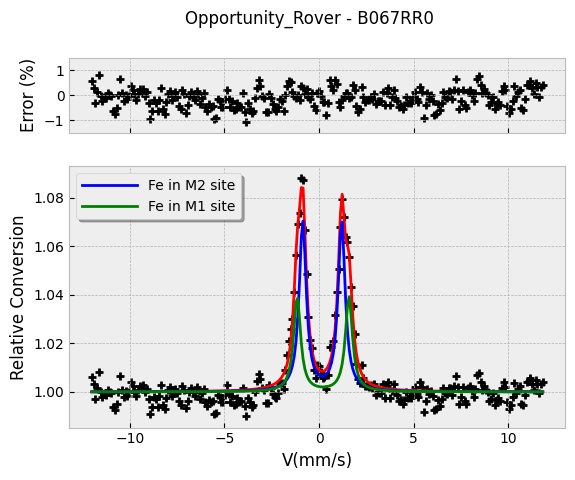

In [ ]:
"""
LECTURA DE ARCHIVO DE ENTRADA
"""
col_list=[0, 1]

x, y= np.loadtxt(f"{full}/{name}.csv", delimiter=",", usecols=col_list, unpack=True)

"""
DEFINICIÓN DE LAS FUNCIONES BASADAS EN LORENTZIANAS
"""
def singlet(a, b, m, x):
    return 2*a*b/(pi*(b**2+4*(x-m)**2))

def doublet(a, b, m, d, x):
    return 2*a*b/(pi*(b**2+4*(x-(m-d/2))**2))+2*a*b/(pi*(b**2+4*(x-(m+d/2))**2))

def sextet(a, b, m, d, q, l23, x):
    return 6*a*b/(pi*(b**2+4*(x-(m+5*d))**2))+l23*2*a*b/(pi*(b**2+4*(x-(m+3*d-q))**2))+2.5*a*b/(pi*(b**2+4*(x-(m+0.75*d))**2))+2.5*a*b/(pi*(b**2+4*(x-(m-0.75*d))**2))+l23*2*a*b/(pi*(b**2+4*(x-(m-3*d+q))**2))+6*a*b/(pi*(b**2+4*(x-(m-5*d))**2))

def voigt_d(av, mv, bl, bg, dl, dg, x):
    return 2*av*bl/(pi*(bl**2+(x-4*(mv-dl/2))**2))+2*av*bl/(pi*(bl**2+(x-4*(mv+dl/2))**2))+(1-av)*np.exp(-(x-(mv-dg/2))**2/(2*bg**2))/(bg*np.sqrt(2*np.pi))+(1-av)*np.exp(-(x-(mv+dg/2))**2/(2*bg**2))/(bg*np.sqrt(2*np.pi))

def linear_fitting_lmfit(params, x, y):
    b1= params['b1']; m1= params['m1']; d1= params['d1']; a1= params['a1']
    b2= params['b2']; m2= params['m2']; d2= params['d2']; a2= params['a2']

    y_fit= 1+(doublet(a1, b1, m1, d1, x))+(doublet(a2, b2, m2, d2, x))

    return y_fit-y

"""
AJUSTE DE LOS PARÁMETROS USANDO LOS DATOS EXPERIMENTALES
"""
params= Parameters()

params.add('b1', value= 0.45, vary=False)
params.add('m1', value= 1.1, vary=True)
params.add('d1', value= 2.1, vary=True)
params.add('a1', value= 0.02, vary=True)
params.add('b2', value= 0.45, vary=False)
params.add('m2', value= 1.2, vary=True)
params.add('d2', value= 2.5, vary=True)
params.add('a2', value= 0.01, vary=True)

fitted_params= minimize(linear_fitting_lmfit, params, args=(x, y,), method='least_square')

m1= fitted_params.params['m1'].value
b1= fitted_params.params['b1'].value
d1= fitted_params.params['d1'].value
a1= fitted_params.params['a1'].value
m2= fitted_params.params['m2'].value
b2= fitted_params.params['b2'].value
d2= fitted_params.params['d2'].value
a2= fitted_params.params['a2'].value

"""
CREACIÓN DE LOS SUBESPECTROS AJUSTADOS
"""
z= 1+(doublet(a1, b1, m1, d1, x))+(doublet(a2, b2, m2, d2, x))
z1= 1+(doublet(a1, b1, m1, d1, x))
z2= 1+(doublet(a2, b2, m2, d2, x))
e= (y-z)/y*100

"""
INTEGRAL DE ÁREAS Y GENERACIÓN DE LOS PARÁMETROS HIPERFINOS. REPORTE EN PANTALLA
"""
int1= trapz(-1+z1, x); int2= trapz(-1+z2, x)

b1= "{0:.2f}".format(b1/np.sqrt(2))
m1= "{0:.3f}".format(m1)
d1= "{0:.3f}".format(d1)
a1= "{0:.4f}".format(a1)
i1= "{0:.1f}".format(100*abs(int1/(int1+int2)))
b2= "{0:.2f}".format(b2/np.sqrt(2))
m2= "{0:.3f}".format(m2)
d2= "{0:.3f}".format(d2)
a2= "{0:.4f}".format(a2)
i2= "{0:.1f}".format(100*abs(int2/(int1+int2)))


print('ancho1 (sigma1/sqrt(2)) es:', b1, 'mm/s')
print('Centroide1 (ISO1) es:', m1, 'mm/s')
print('Amplitud1 (a1) es:', a1)
print('Doblete1 es:', d1, 'mm/s')
print('área1:', i1, '%')
print('ancho2 (sigma2/sqrt(2)) es:', b2, 'mm/s')
print('Centroide2 (ISO2) es:', m2, 'mm/s')
print('Amplitud2 (a2) es:', a2)
print('Doblete2 es:', d2, 'mm/s')
print('área2:', i2, '%')
print(fit_report(fitted_params))

"""
GRAFICA DE ESPECTROS Y SUBESPECTROS
"""
plt.style.use('bmh')

fig, (ax1, ax2) = plt.subplots(2, sharex=True, height_ratios=[1,3.5]); fig.suptitle(f"{title}" " - " f"{name}")
ax1.scatter (x, e, c= 'black', marker='+')
ax1.set_ylim(-1.5,1.5)
ax1.set_ylabel('Error (%)')

ax2.scatter (x, y, c= 'black', marker='+')
ax2.set_xlabel('V(mm/s)')
ax2.set_ylabel('Relative Conversion')
ax2.plot(x, z, c='red')
ax2.plot(x, z1, c='blue', label='Fe in M2 site')
ax2.plot(x, z2, c='green', label='Fe in M1 site')
ax2.legend(handlelength=4, loc='upper left', shadow=True)
plt.show()

"""
GENERACIÓN DE ARCHIVOS DE SALIDA: DATOS Y PARÁMETROS
"""
np.savetxt(f"{full}/{name}-plot.csv", list(zip(x,y, z, z1, z2)), fmt='%1.6e')

df= pd.DataFrame ({'Ancho(mm/s)': [b1, b2], 'IS (mm/s)': [m1, m2], 'Quad Splitting (mm/s)': [d1, d2], 'Bhf (T)': [0,0], 'Área(%)': [i1, i2]})
df.to_csv(f"{full}/{name}-report.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# 1. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Cargar datos de referencia (base de datos)
reference_path = '/content/drive/MyDrive/Colab-Notebooks/PyMossFit/reference_data.csv'  # ¡Ajusta la ruta!
df_ref = pd.read_csv(reference_path)

# Función para convertir rangos a valores medios (ej: "0.37-0.45" → 0.41)
def parse_value(value):
    if isinstance(value, str) and '-' in value:
        min_val, max_val = map(float, value.split('-'))
        return (min_val + max_val) / 2
    return float(value)

# Procesar columnas relevantes
cols = ['IS (mm/s)', 'Quad Splitting (mm/s)', 'Bhf (T)']
for col in cols:
    df_ref[col] = df_ref[col].apply(parse_value)

# 3. Cargar datos experimentales
experimental_path = f"{full}/{name}-report.csv"  # ¡Ajusta la ruta!
df_exp = pd.read_csv(experimental_path)

# 4. Preprocesar datos experimentales (manejar NaN)
X_exp = df_exp[cols].fillna(0).values  # Si Bhf no existe, reemplazar NaN por 0

# 5. Entrenar modelo KNN
X_ref = df_ref[cols].values
model = NearestNeighbors(n_neighbors=8, metric='euclidean')
model.fit(X_ref)

# 6. Encontrar coincidencias
distances, indices = model.kneighbors(X_exp)

# 7. Mostrar resultados
for i, (dist, idx) in enumerate(zip(distances, indices)):
    print(f"\nMuestra experimental {i+1}:")
    for j, (d, pos) in enumerate(zip(dist, idx)):
        compound = df_ref.iloc[pos]['Compound Name']
        formula = df_ref.iloc[pos]['Chemical Formula']
        is_ref = df_ref.iloc[pos]['IS (mm/s)']
        qs_ref = df_ref.iloc[pos]['Quad Splitting (mm/s)']
        bhf_ref = df_ref.iloc[pos]['Bhf (T)']
        print(f"  Match {j+1}: {compound} ({formula})")
        print(f"    IS: {is_ref:.2f} mm/s | QS: {qs_ref:.2f} mm/s | Bhf: {bhf_ref:.1f} T")
        print(f"    Distancia euclidiana: {d:.2f}\n")

print("## Usar este resultado a modo orientativo. Se recomienda contar con información de la muestra en su composición y estructura ##")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Muestra experimental 1:
  Match 1: Fe(CO)₅ (Fe(CO)₅)
    IS: 0.25 mm/s | QS: 0.05 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 2.11

  Match 2: Fe(phen)₂(NCS)₂ ([Fe(phen)₂(NCS)₂])
    IS: 0.05 mm/s | QS: 0.05 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 2.11

  Match 3: Fe₄[Fe(CN)₆]₃·xH₂O (Fe₄[Fe(CN)₆]₃·xH₂O)
    IS: 0.05 mm/s | QS: 0.10 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 2.16

  Match 4: Prussian Blue (Fe₄[Fe(CN)₆]₃)
    IS: 0.05 mm/s | QS: 0.10 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 2.16

  Match 5: Fe₃[Fe(CN)₆]₂ (Fe₃[Fe(CN)₆]₂)
    IS: 0.15 mm/s | QS: 0.20 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 2.26

  Match 6: Hemoglobina (oxy) (Fe(C₃4H₃2N4O4))
    IS: 0.25 mm/s | QS: 0.30 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 2.36

  Match 7: Fe(phen)₂(NCS)₂ ([Fe(phen)₂(NCS)₂])
    IS: 0.35 mm/s | QS: 0.30 mm/s | Bhf: 0.0 T
    Distancia euclidian